## MMD ResNet for RNA data

Use GTEX as source and TCGA as target since there are 2445 GTEX samples and only 683 TCGA samples

### Imports

In [25]:
import os.path
import keras.optimizers
from Calibration_Util import DataHandler as dh 
from Calibration_Util import FileIO as io
from keras.layers import Input, Dense, merge, Activation, add
from keras.models import Model
from keras import callbacks as cb
import numpy as np
import matplotlib
from keras.layers.normalization import BatchNormalization
#detect display
import os
havedisplay = "DISPLAY" in os.environ
#if we have a display use a plotting backend
if havedisplay:
    matplotlib.use('TkAgg')
else:
    matplotlib.use('Agg')

import CostFunctions as cf
import Monitoring as mn
from keras.regularizers import l2
from sklearn import decomposition
from keras.callbacks import LearningRateScheduler
import math
import ScatterHist as sh
from keras import initializers
from numpy import genfromtxt
import sklearn.preprocessing as prep
import tensorflow as tf
import keras.backend as K

### Configure hyperparameters

In [26]:
mmdNetLayerSizes = [25, 25]
l2_penalty = 1e-2

### Load Data

In [27]:
sourcePath = os.path.join(io.DeepLearningRoot(), 'data/gtex_batch2.csv')
targetPath = os.path.join(io.DeepLearningRoot(), 'data/tcga_batch1.csv')

In [35]:
source = genfromtxt(sourcePath, delimiter=',', skip_header=1)
print(source[1,:])
source.shape

[ -1.42110630e+06  -8.09105294e+05  -2.21625642e+05  -2.70976409e+04
   2.25280928e+04  -1.01543954e+03  -1.26163436e+05   1.98825592e+05
   2.67028862e+03   3.03464358e+05  -1.89857558e+05  -1.11616625e+05
   7.40879854e+03   2.52422265e+04   1.72237275e+04  -1.12197097e+05
  -8.11428970e+03   1.10057459e+05   4.30845564e+04  -2.88909674e+04
   6.35710050e+04   6.68471965e+04   4.49351975e+04   3.38918520e+04
   1.13327467e+04]


(2445, 25)

In [29]:
target = genfromtxt(targetPath, delimiter=',', skip_header=1)
inputDim = target.shape[1]
target.shape

(683, 25)

### Build MMD Net

In [30]:
# input
calibInput = Input(shape=(inputDim, ))

# block 1
block1_bn1 = BatchNormalization()(calibInput)
block1_a1 = Activation('relu')(block1_bn1)
block1_w1 = Dense(mmdNetLayerSizes[1], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block1_a1)
block1_bn2 = BatchNormalization()(block1_w1)
block1_a2 = Activation('relu')(block1_bn2)
block1_w2 = Dense(mmdNetLayerSizes[0], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block1_a2)
block1_output = add([block1_w2, calibInput])

# block 2
block2_bn1 = BatchNormalization()(block1_output)
block2_a1 = Activation('relu')(block2_bn1)
block2_w1 = Dense(mmdNetLayerSizes[1], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block2_a1)
block2_bn2 = BatchNormalization()(block1_w1)
block2_a2 = Activation('relu')(block2_bn2)
block2_w2 = Dense(mmdNetLayerSizes[0], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block2_a2)
block2_output = add([block2_w2, calibInput])

# block 3
block3_bn1 = BatchNormalization()(block2_output)
block3_a1 = Activation('relu')(block3_bn1)
block3_w1 = Dense(mmdNetLayerSizes[1], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block3_a1)
block3_bn2 = BatchNormalization()(block3_w1)
block3_a2 = Activation('relu')(block3_bn2)
block3_w2 = Dense(mmdNetLayerSizes[0], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block3_a2)
block3_output = add([block3_w2, calibInput])

calibMMDNet = Model(inputs=calibInput, outputs=block2_output)

### Prepare for Training

In [37]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 150.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

optimizer = keras.optimizers.rmsprop(lr=0.0)

calibMMDNet.compile(optimizer=optimizer, 
                    loss=lambda y_true,y_pred: 
                       cf.MMD(block2_output,target,MMDTargetValidation_split=0.1).KerasCost(y_true,y_pred)
                   )
K.get_session().run(tf.global_variables_initializer())

sourceLabels = np.zeros(source.shape[0])

setting scales using KNN
[190086.77546116279, 380173.55092232558, 760347.10184465116]
setting all scale weights to 1


### Train

In [32]:
calibMMDNet.fit(source, sourceLabels, nb_epoch=500 ,batch_size=100, validation_split=0.1, verbose=1,
               callbacks=[lrate, mn.monitorMMD(source, target, calibMMDNet.predict),
                          cb.EarlyStopping(monitor='val_loss',patience=50,mode='auto')]
               )

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  app.launch_new_instance()


Train on 2200 samples, validate on 245 samples
Epoch 1/500
2200/2200 [==============================] - 1s 675us/step - loss: 0.6258 - val_loss: 1.0145
Epoch 2/500
2200/2200 [==============================] - 1s 306us/step - loss: 0.6244 - val_loss: 1.0146
Epoch 3/500
2200/2200 [==============================] - 1s 287us/step - loss: 0.6236 - val_loss: 1.0148
Epoch 4/500
2200/2200 [==============================] - 1s 305us/step - loss: 0.6228 - val_loss: 1.0148
Epoch 5/500
2200/2200 [==============================] - 1s 306us/step - loss: 0.6222 - val_loss: 1.0147
Epoch 6/500
2200/2200 [==============================] - 1s 307us/step - loss: 0.6236 - val_loss: 1.0148
Epoch 7/500
2200/2200 [==============================] - 1s 305us/step - loss: 0.6235 - val_loss: 1.0148
Epoch 8/500
2200/2200 [==============================] - 1s 306us/step - loss: 0.6247 - val_loss: 1.0148
Epoch 9/500
2200/2200 [==============================] - 1s 307us/step - loss: 0.6252 - val_loss: 1.0148
Epoch 10

### Evaluate Results

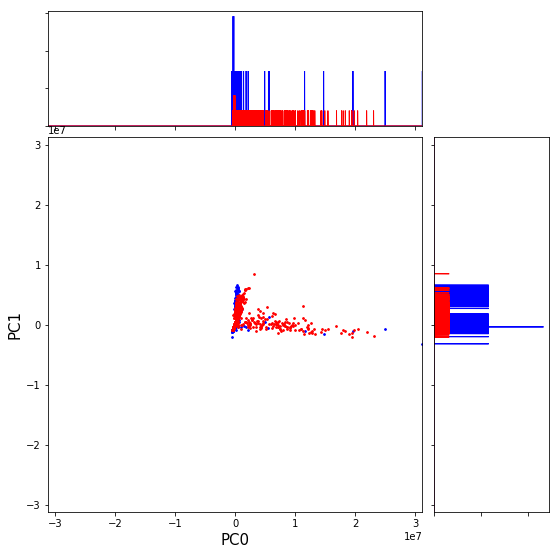

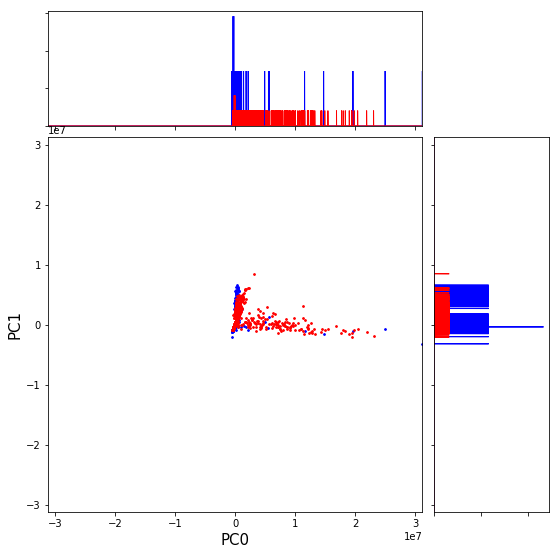

In [33]:
%matplotlib inline
calibratedSource = calibMMDNet.predict(source)

##################################### qualitative evaluation: PCA #####################################
pca = decomposition.PCA()
pca.fit(target)

# project data onto PCs
target_sample_pca = pca.transform(target)
projection_before = pca.transform(source)
projection_after = pca.transform(calibratedSource)

# choose PCs to plot
pc1 = 0
pc2 = 1
axis1 = 'PC'+str(pc1)
axis2 = 'PC'+str(pc2)
sh.scatterHist(target_sample_pca[:,pc1], target_sample_pca[:,pc2], projection_before[:,pc1], 
               projection_before[:,pc2], axis1, axis2)
sh.scatterHist(target_sample_pca[:,pc1], target_sample_pca[:,pc2], projection_after[:,pc1], 
               projection_after[:,pc2], axis1, axis2)